In [44]:
import numpy as np 
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
%matplotlib inline

# Data Load and Analysis
### Imagewoof dataset is available on https://github.com/fastai/imagenette . 

 `print(imagewoof_info)` gives following Information regarding the dataset:

*   `image.shape` -> (shape=(None, None, 3) we recognize that the images contained in the dataset have different sizes
*   By num_classes=10 we know that all images belong to 10 classes, or categories
*   total_num_examples=12954 indicates the number of images
*   Also, the images are already divided into "train" and "validation" and contain 9025 and 3929 images, respectively.


In [45]:
# Connect Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=12954,
    splits={
        'train': 9025,
        'val': 3929,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)

(255, 500, 3) 6
(505, 479, 3) 0
(428, 485, 3) 0
(500, 375, 3) 6
Train
9025


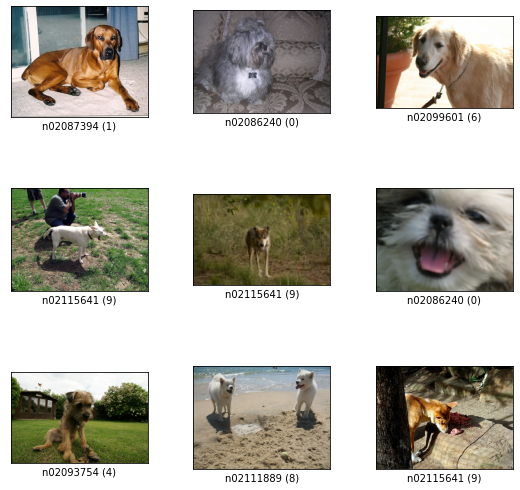

Test
3929


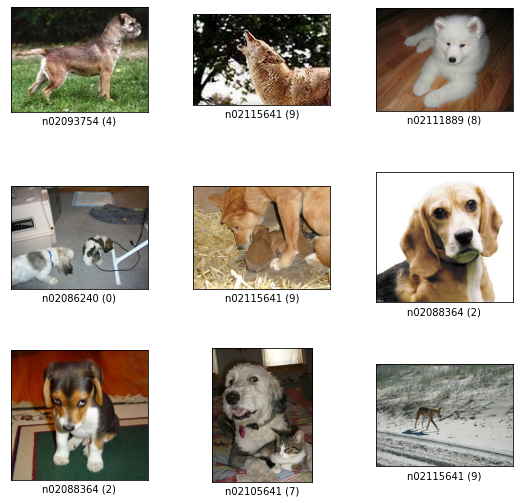

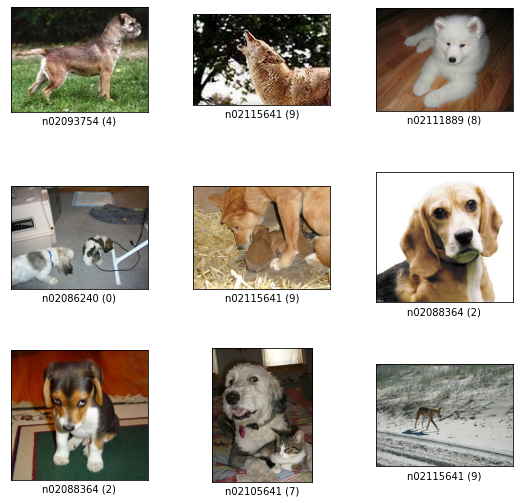

In [46]:
# reference :- https://www.tensorflow.org/datasets/overview
batch_size = 128
#imagenette_builder = tfds.builder("imagewoof/full-size-v2")

data_dir = '/content/gdrive/MyDrive/Colab_Notebooks/CVDL_Project/imagewoof2'
imagewoof_builder = tfds.ImageFolder(data_dir) # ImageFolder creates a tf.data.Dataset reading the original image files.
'''print(imagenette_builder.info)  # num examples, labels... are automatically calculated
ds = builder.as_dataset(split='train',as_supervised=True, shuffle_files=True)
tfds.show_examples(ds, builder.info)'''


imagewoof_info = imagewoof_builder.info
print(imagewoof_info)

#imagenette_builder.download_and_prepare()
datasets = imagewoof_builder.as_dataset(as_supervised=True,shuffle_files=True)
(train_datasets,test_datasets)=imagewoof_builder.as_dataset(split=['train', 'val'],as_supervised=True, shuffle_files=True)
train_examples = imagewoof_info.splits['train'].num_examples
validation_examples = imagewoof_info.splits['val'].num_examples


ds= train_datasets.take(4)  # Only take a few example
for image, label in ds:  # example is (image, label)
  print(image.shape, tfds.as_numpy(label))


print("Train")
print(train_examples)
tfds.show_examples(train_datasets, imagewoof_builder.info)

print("Test")
print(validation_examples)
tfds.show_examples(test_datasets, imagewoof_builder.info)


,image,label
0,,3 (n02089973)
1,,5 (n02096294)
2,,4 (n02093754)
3,,6 (n02099601)

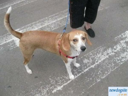
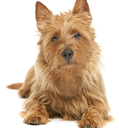
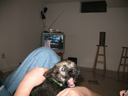
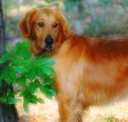

In [47]:
tfds.as_dataframe(train_datasets.take(4), imagewoof_builder.info)

In [48]:
info = imagewoof_builder.info
print(info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


Finally, there are 10 classes to which the images are assigned.  `print(info.features['label'].names)` goves this information.
Look into the images and determine the class label .

https://github.com/fastai/imagenette shows Imagenet classes are (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [49]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(1))  # Human readable version (1 -> 'n02087394'->'gas pump')
print(info.features["label"].str2int('n02087394'))
class_labels = [0,1,2,3,4,5,6,7,8,9] 
lbl_dict = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed', 
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
)

for i, value in lbl_dict.items():
  index=info.features["label"].str2int(i)
  print(index, value)
  class_labels[index]=value

print(class_labels) 

10
['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']
n02087394
1
4 Australian terrier
3 Border terrier
6 Samoyed
1 Beagle
7 Shih-Tzu
5 English foxhound
2 Rhodesian ridgeback
9 Dingo
8 Golden retriever
0 Old English sheepdog
['Old English sheepdog', 'Beagle', 'Rhodesian ridgeback', 'Border terrier', 'Australian terrier', 'English foxhound', 'Samoyed', 'Shih-Tzu', 'Golden retriever', 'Dingo']


In [50]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

{'image': (None, None, 3), 'label': (), 'image/filename': ()}
{'image': tf.uint8, 'label': tf.int64, 'image/filename': tf.string}
(None, None, 3)
<dtype: 'uint8'>


In [51]:
print(info.splits)
print(list(info.splits.keys()))

{'train': <tfds.core.SplitInfo num_examples=9025>, 'val': <tfds.core.SplitInfo num_examples=3929>}
['train', 'val']


# Preprocessing steps

1.   Resize all the images (128,128, 3)
2.   Normalize pixel values of each image so that they are all in a   range between 0 and 1. Normally the value of a pixel is between 0 and 255 (RGB color values), but the neural networks prefer to calculate with values between 0 and 1, so we will simply divide each pixel value by 255.




In [52]:
size_image = 128
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(size_image, size_image,crop_to_aspect_ratio=True),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
]) 

In [53]:
train_datasets = train_datasets.map(
  lambda image,label: (resize_and_rescale(image, training=True),label)) 

In [54]:
test_datasets = test_datasets.map(
  lambda image, label: (resize_and_rescale(image, training=False), label)) 

In [55]:
for img, label in train_datasets.take(5):
  print(img.shape,label) 

(128, 128, 3) tf.Tensor(0, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(6, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(4, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(1, shape=(), dtype=int64)
(128, 128, 3) tf.Tensor(1, shape=(), dtype=int64)


In [56]:
def plot_images(data, size=(20,20)):
  plt.figure(figsize=size)
  for i in range(25):
    for img, label in data.take(i+1):
      plt.subplot(5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(True)
      plt.imshow(img, cmap=plt.cm.binary)
      plt.title(class_labels[label])
      plt.ylabel(img.shape)
  plt.show() 

In [57]:
plot_images(train_datasets) 

Output hidden; open in https://colab.research.google.com to view.

# Model

In [58]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding='same', activation=tf.keras.layers.ReLU(),input_shape=(128,128,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.keras.layers.ReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation=tf.keras.layers.ReLU()),    
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10,activation='softmax')]) 

In [59]:
model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                      

In [60]:
train_batch = train_datasets.batch(128)

test_batch = test_datasets.batch(128) 

In [61]:
for img, label in train_batch.take(5):
  print(img.shape,label) 

(128, 128, 128, 3) tf.Tensor(
[3 1 7 9 3 9 3 6 6 6 5 7 1 6 4 0 2 2 2 6 1 4 9 3 6 1 4 2 2 0 8 0 4 5 5 5 9
 4 3 1 5 7 8 2 8 8 7 9 6 1 1 2 7 3 8 0 3 6 3 6 5 6 6 2 4 7 7 4 9 9 2 0 4 5
 7 2 3 6 7 8 6 1 8 5 9 7 5 1 6 4 4 9 6 1 0 4 6 6 1 9 0 8 1 0 6 4 1 6 2 7 6
 0 6 0 6 7 0 6 8 1 2 1 8 7 8 9 7 1], shape=(128,), dtype=int64)
(128, 128, 128, 3) tf.Tensor(
[4 0 1 7 8 8 6 2 6 9 9 2 9 6 7 6 4 7 0 4 4 6 9 6 9 6 9 5 9 1 8 9 9 7 7 9 8
 4 2 1 6 1 7 7 8 9 5 0 4 0 6 0 7 8 1 7 8 8 5 7 1 9 5 6 5 1 3 2 6 2 1 0 9 2
 4 7 8 2 1 2 7 5 1 5 5 3 8 1 5 7 0 6 0 4 0 2 0 4 7 2 8 0 4 2 6 6 9 0 1 2 6
 4 2 3 7 9 4 5 0 5 8 9 8 3 3 1 5 5], shape=(128,), dtype=int64)
(128, 128, 128, 3) tf.Tensor(
[1 9 7 8 3 4 7 0 5 5 7 8 2 1 7 3 4 9 1 1 1 8 0 1 7 0 0 4 6 4 7 8 5 5 6 2 9
 0 0 0 0 0 1 0 9 8 5 5 9 2 4 5 7 0 9 2 6 6 1 4 0 7 1 5 0 0 8 5 4 3 1 1 3 7
 9 8 2 6 9 6 8 9 7 6 7 3 0 6 0 3 9 1 4 1 0 0 2 0 2 9 1 1 4 2 8 5 5 6 0 0 9
 7 9 0 1 8 2 4 3 0 0 5 5 2 8 6 0 7], shape=(128,), dtype=int64)
(128, 128, 128, 3) tf.Tensor(
[8 0 5 4 9 5 

In [62]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) 


In [63]:
history = model.fit(train_batch,epochs=100,validation_data=test_batch,callbacks=[es]) 

Epoch 1/100
71/71 [==============================] - 644s 9s/step - loss: 2.5753 - accuracy: 0.1735 - val_loss: 2.3940 - val_accuracy: 0.1161
Epoch 2/100
71/71 [==============================] - 20s 284ms/step - loss: 2.2527 - accuracy: 0.2363 - val_loss: 2.4094 - val_accuracy: 0.1453
Epoch 3/100
71/71 [==============================] - 20s 284ms/step - loss: 2.0598 - accuracy: 0.2811 - val_loss: 2.3923 - val_accuracy: 0.1756
Epoch 4/100
71/71 [==============================] - 20s 287ms/step - loss: 1.9424 - accuracy: 0.3180 - val_loss: 2.4665 - val_accuracy: 0.1631
Epoch 5/100
71/71 [==============================] - 20s 284ms/step - loss: 1.8525 - accuracy: 0.3493 - val_loss: 2.5302 - val_accuracy: 0.1542
Epoch 6/100
71/71 [==============================] - 20s 284ms/step - loss: 1.7503 - accuracy: 0.3806 - val_loss: 2.2979 - val_accuracy: 0.2151
Epoch 7/100
71/71 [==============================] - 20s 287ms/step - loss: 1.6711 - accuracy: 0.4176 - val_loss: 2.0878 - val_accuracy: 0

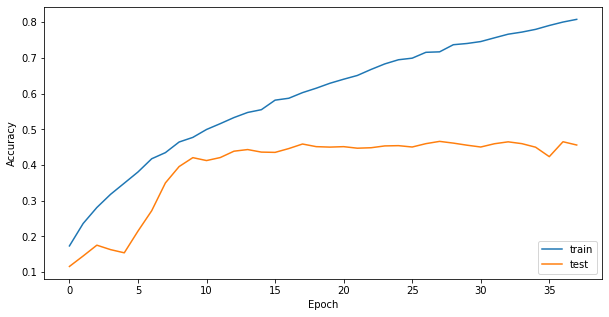

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right') 

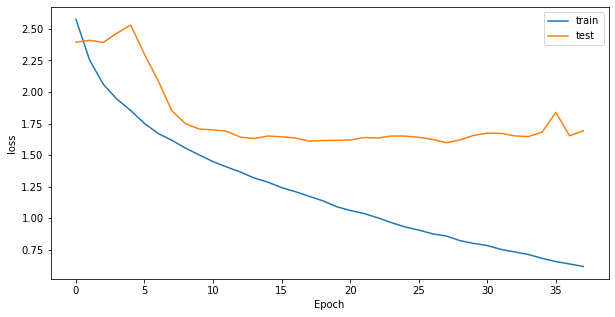

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right') 

In [66]:
test_acc = model.evaluate(test_batch, verbose=2)
print('Test accuracy: ',test_acc[1]) 
print('Test loss: ',test_acc[0])


31/31 - 6s - loss: 1.6914 - accuracy: 0.4561 - 6s/epoch - 190ms/step
Test accuracy:  0.45609569549560547
Test loss:  1.6914212703704834


In [67]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [68]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                100*np.max(predictions_array),
                                class_labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [69]:
labels =[]
labels_hat=[]
for image, label in test_batch:
  y_pred=model.predict(image)
  classes = np.argmax(y_pred,axis = 1)
  labels.extend(list(label.numpy()))
  labels_hat.extend(list(classes))

con_mat = tf.math.confusion_matrix(labels=labels, predictions=labels_hat).numpy()

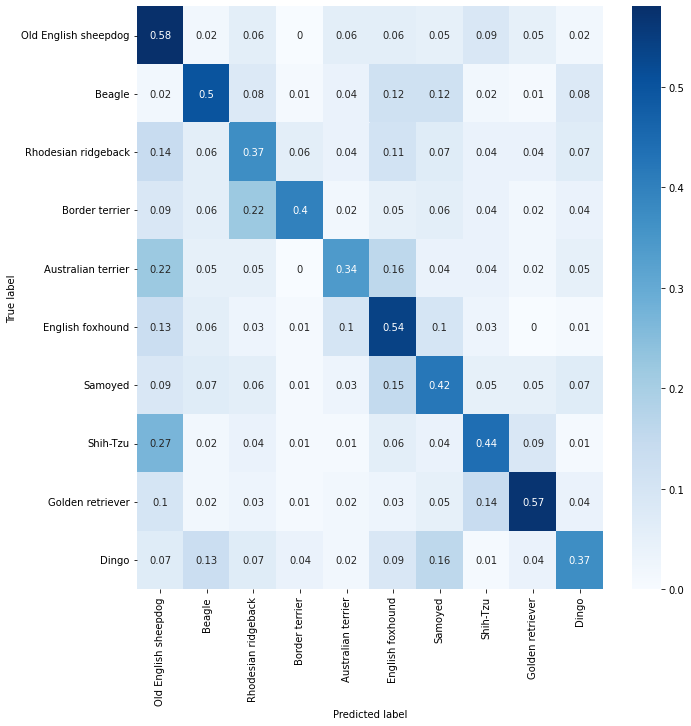

In [70]:
import pandas as pd
import seaborn as sns

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_labels, 
                     columns = class_labels)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [71]:
#reference:- https://www.tensorflow.org/tutorials/keras/classification
for test_images, test_labels in test_batch.take(5):  
  for l in range(len(label)):
    predictions = probability_model.predict(test_images)
    i = l
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(1,2,2)
    plot_value_array(i, predictions[i],  test_labels)
    plt.show()
  

Output hidden; open in https://colab.research.google.com to view.